<a href="https://colab.research.google.com/github/Sinjan-Debnath/employee-sentiment-analysis/blob/main/employee_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# For sentiment analysis
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# For machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# For text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download NLTK resources
try:
    nltk.download('punkt')
    nltk.download('stopwords')
except:
    pass

print("All libraries imported successfully!")

All libraries imported successfully!


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#@title Section 1: Data Loading and Initial Exploration
print("=" * 60)
print("SECTION 1: DATA LOADING AND INITIAL EXPLORATION")
print("=" * 60)

# Load the dataset
from google.colab import files
import io

print("Please upload the test.csv file")
uploaded = files.upload()

# Read the dataset
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))

print(f"Dataset loaded successfully: {filename}")
print(f"Dataset shape: {df.shape}")

# Display basic information about the dataset
print("\n" + "=" * 40)
print("DATASET OVERVIEW")
print("=" * 40)
print(df.head())

print("\n" + "=" * 40)
print("DATASET INFORMATION")
print("=" * 40)
print(df.info())

print("\n" + "=" * 40)
print("COLUMN NAMES")
print("=" * 40)
print(df.columns.tolist())

print("\n" + "=" * 40)
print("MISSING VALUES")
print("=" * 40)
print(df.isnull().sum())

print("\n" + "=" * 40)
print("BASIC STATISTICS")
print("=" * 40)
print(df.describe())

SECTION 1: DATA LOADING AND INITIAL EXPLORATION
Please upload the test.csv file


Saving test(in).csv to test(in) (2).csv
Dataset loaded successfully: test(in) (2).csv
Dataset shape: (2191, 4)

DATASET OVERVIEW
                                        Subject  \
0                          EnronOptions Update!   
1                                  (No Subject)   
2  Phone Screen  Interview - Shannon L. Burnham   
3                         RE: My new work email   
4                                           Bet   

                                                body       date  \
0  EnronOptions Announcement\n\n\nWe have updated...  5/10/2010   
1  Marc,\n\nUnfortunately, today is not going to ...  7/29/2010   
2  When: Wednesday, June 06, 2001 10:00 AM-11:00 ...  7/25/2011   
3  we were thinking papasitos (we can meet somewh...  3/25/2010   
4  Since you never gave me the $20 for the last t...  5/21/2011   

                      from  
0     sally.beck@enron.com  
1      eric.bass@enron.com  
2     sally.beck@enron.com  
3  johnny.palmer@enron.com  
4  lydia.delgado

In [3]:
#@title Section 2: Data Preprocessing
print("=" * 60)
print("SECTION 2: DATA PREPROCESSING")
print("=" * 60)

# --- FIX: Manually set the correct column names ---
# The 'from' column identifies the employee, and 'body' contains the message text.
message_col = 'body'
employee_col = 'from'
date_col = 'date'

print(f"\nUsing columns:")
print(f"Message: {message_col}")
print(f"Employee: {employee_col}")
print(f"Date: {date_col}")

# Clean the data
print("\n" + "=" * 40)
print("DATA CLEANING")
print("=" * 40)

# Handle missing values by dropping rows where key columns are empty
initial_rows = len(df)
df_clean = df.dropna(subset=[message_col, employee_col, date_col]).copy()
rows_after_cleaning = len(df_clean)

print(f"Rows before cleaning: {initial_rows}")
print(f"Rows after cleaning: {rows_after_cleaning}")
print(f"Rows removed: {initial_rows - rows_after_cleaning}")

# Convert date column to datetime objects
try:
    df_clean['date_parsed'] = pd.to_datetime(df_clean[date_col])
    print("Date conversion successful")
except Exception as e:
    print(f"Date conversion failed: {e}")
    # As a fallback, create dummy dates if conversion fails
    df_clean['date_parsed'] = pd.to_datetime(pd.Series([datetime(2023, 1, 1)] * len(df_clean)))

# Extract month and year for easier grouping
df_clean['year'] = df_clean['date_parsed'].dt.year
df_clean['month'] = df_clean['date_parsed'].dt.month
df_clean['year_month'] = df_clean['date_parsed'].dt.to_period('M')

print(f"\nDate range: {df_clean['date_parsed'].min()} to {df_clean['date_parsed'].max()}")
print(f"Number of unique employees: {df_clean[employee_col].nunique()}")
print(f"Number of unique months: {df_clean['year_month'].nunique()}")

# Display cleaned data
print("\nFirst few rows of cleaned data:")
print(df_clean[[employee_col, message_col, 'date_parsed', 'year_month']].head())

SECTION 2: DATA PREPROCESSING

Using columns:
Message: body
Employee: from
Date: date

DATA CLEANING
Rows before cleaning: 2191
Rows after cleaning: 2191
Rows removed: 0
Date conversion successful

Date range: 2010-01-01 00:00:00 to 2011-12-31 00:00:00
Number of unique employees: 10
Number of unique months: 24

First few rows of cleaned data:
                      from                                               body  \
0     sally.beck@enron.com  EnronOptions Announcement\n\n\nWe have updated...   
1      eric.bass@enron.com  Marc,\n\nUnfortunately, today is not going to ...   
2     sally.beck@enron.com  When: Wednesday, June 06, 2001 10:00 AM-11:00 ...   
3  johnny.palmer@enron.com  we were thinking papasitos (we can meet somewh...   
4  lydia.delgado@enron.com  Since you never gave me the $20 for the last t...   

  date_parsed year_month  
0  2010-05-10    2010-05  
1  2010-07-29    2010-07  
2  2011-07-25    2011-07  
3  2010-03-25    2010-03  
4  2011-05-21    2011-05  


SECTION 3: SENTIMENT LABELING
Initializing sentiment analysis model...


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


Roberta sentiment model loaded successfully!

Performing sentiment analysis on all messages...
NOTE: This will take several minutes to run on the full dataset...

Sentiment analysis completed!

Sentiment Distribution:
sentiment
Neutral     1654
Positive     424
Negative     113
Name: count, dtype: int64


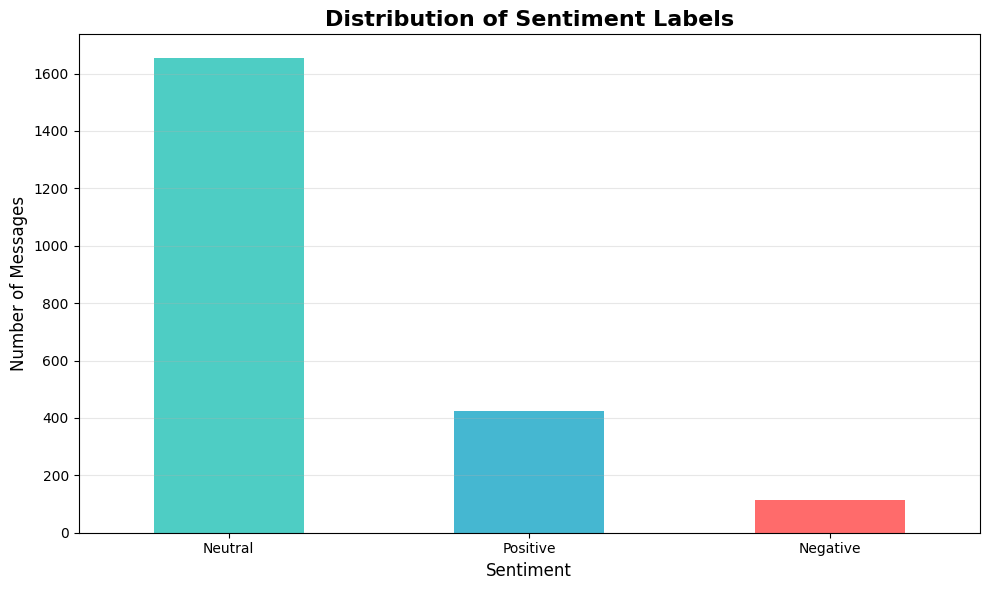


Final dataset shape with sentiment labels: (2191, 9)
                       from  \
0      sally.beck@enron.com   
1       eric.bass@enron.com   
2      sally.beck@enron.com   
3   johnny.palmer@enron.com   
4   lydia.delgado@enron.com   
5       eric.bass@enron.com   
6   kayne.coulter@enron.com   
7  patti.thompson@enron.com   
8      sally.beck@enron.com   
9   kayne.coulter@enron.com   

                                                body sentiment  
0  EnronOptions Announcement\n\n\nWe have updated...   Neutral  
1  Marc,\n\nUnfortunately, today is not going to ...   Neutral  
2  When: Wednesday, June 06, 2001 10:00 AM-11:00 ...   Neutral  
3  we were thinking papasitos (we can meet somewh...   Neutral  
4  Since you never gave me the $20 for the last t...   Neutral  
5  sure, just call me the bank that delivers.\n \...   Neutral  
6  Inventory summaries for both MGL and MGMCC as ...   Neutral  
7  Please print attachment and make sure that e:m...   Neutral  
8  Please advise me

In [4]:
#@title Section 3: Sentiment Labeling using LLM (Updated)
print("=" * 60)
print("SECTION 3: SENTIMENT LABELING")
print("=" * 60)

print("Initializing sentiment analysis model...")

# Use a pre-trained sentiment analysis model from Hugging Face Transformers
try:
    sentiment_pipeline = pipeline(
        "sentiment-analysis",
        model="cardiffnlp/twitter-roberta-base-sentiment-latest",
        tokenizer="cardiffnlp/twitter-roberta-base-sentiment-latest"
    )
    print("Roberta sentiment model loaded successfully!")
except Exception as e:
    print(f"Could not load transformer model: {e}")
    sentiment_pipeline = None

def analyze_sentiment(text):
    """
    Analyze sentiment of a given text using the transformer pipeline.
    Truncates text to 512 characters as required by the model.
    """
    if sentiment_pipeline is not None:
        try:
            # The model has a token limit, so truncate long texts
            truncated_text = str(text)[:512]
            result = sentiment_pipeline(truncated_text)[0]
            label = result['label'].lower()

            if 'positive' in label:
                return 'Positive'
            elif 'negative' in label:
                return 'Negative'
            else:
                return 'Neutral'
        except Exception:
            # Fallback for any errors during pipeline execution
            return 'Neutral'
    else:
        # If the pipeline failed to load, return Neutral for all
        return 'Neutral'

print("\nPerforming sentiment analysis on all messages...")
print("NOTE: This will take several minutes to run on the full dataset...")

df_final = df_clean.copy()
df_final['sentiment'] = df_final[message_col].apply(analyze_sentiment)

print("\nSentiment analysis completed!")
print("\nSentiment Distribution:")
sentiment_counts = df_final['sentiment'].value_counts()
print(sentiment_counts)

# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
colors = ['#4ECDC4', '#45B7D1', '#FF6B6B'] # Adjusted colors for consistency
sentiment_counts.plot(kind='bar', color=colors)
plt.title('Distribution of Sentiment Labels', fontsize=16, fontweight='bold')
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Number of Messages', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nFinal dataset shape with sentiment labels: {df_final.shape}")
print(df_final[[employee_col, message_col, 'sentiment']].head(10))

SECTION 4: EXPLORATORY DATA ANALYSIS
Performing comprehensive EDA...

4.1 BASIC DATASET OVERVIEW
Total number of messages: 2191
Number of unique employees: 10
Date range: 2010-01-01 00:00:00 to 2011-12-31 00:00:00
Number of months covered: 24

4.2 SENTIMENT ANALYSIS


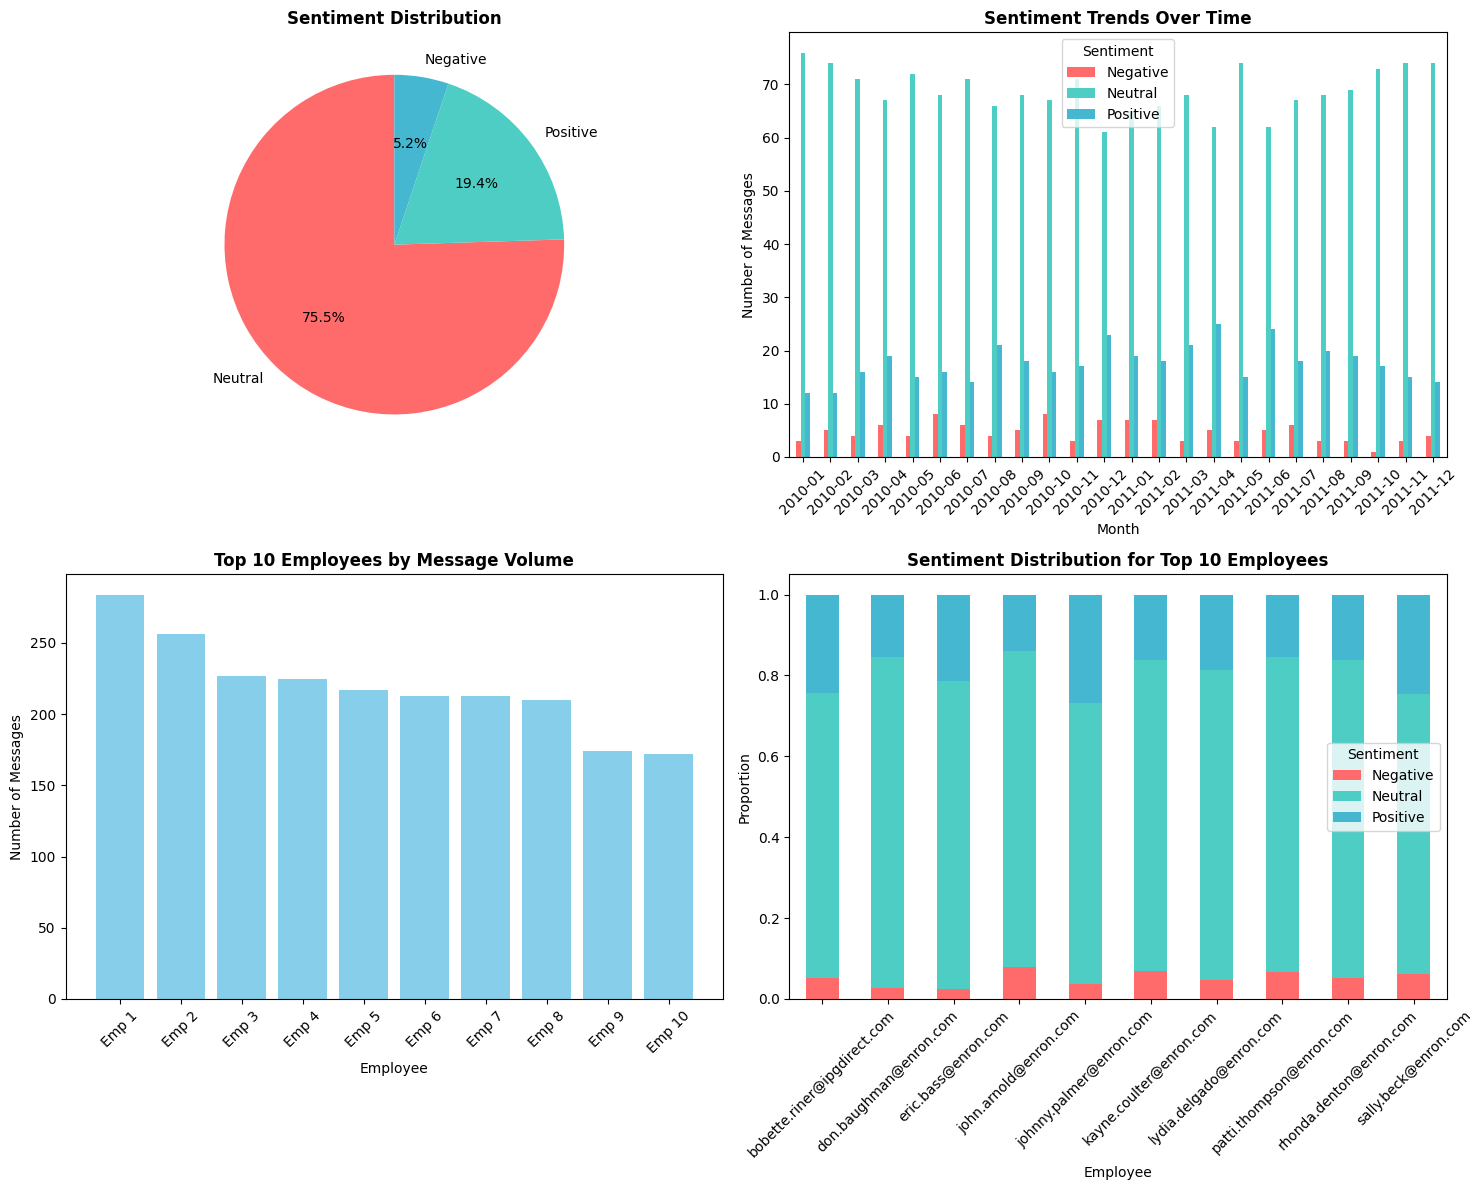


4.3 TEMPORAL ANALYSIS


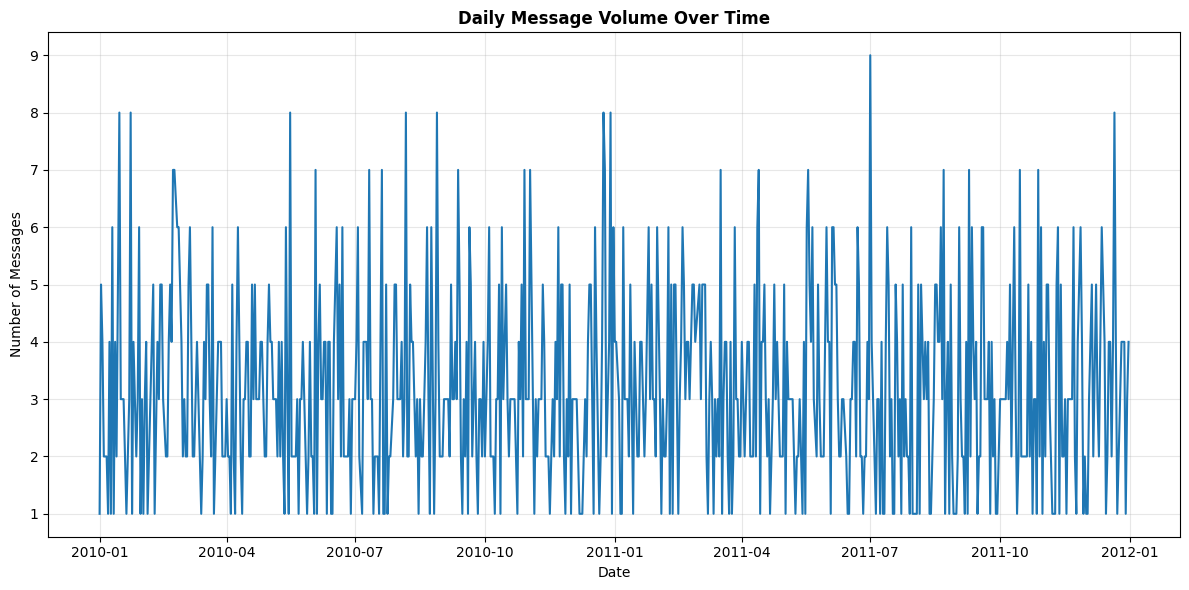

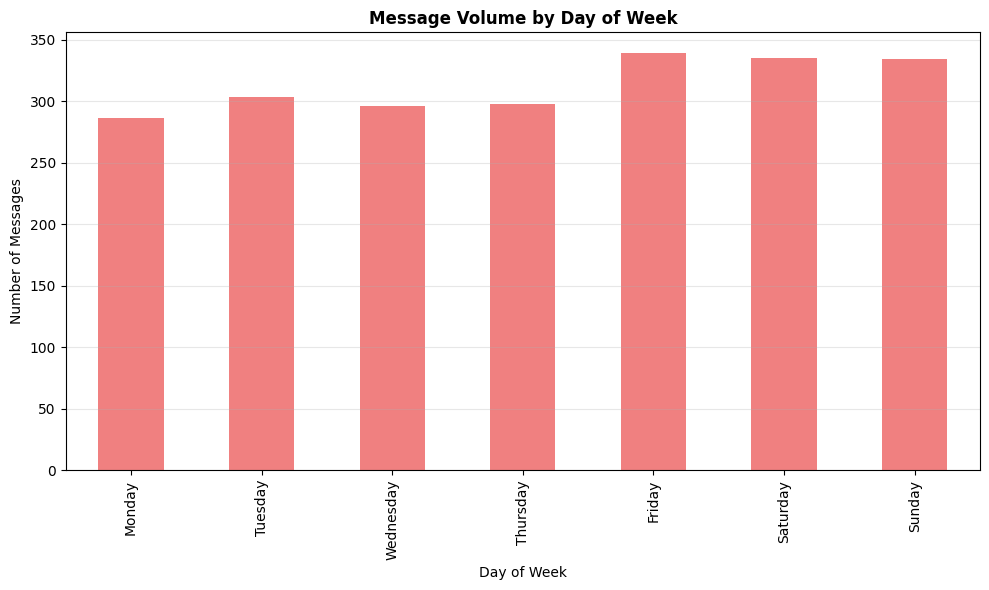


4.4 MESSAGE LENGTH ANALYSIS


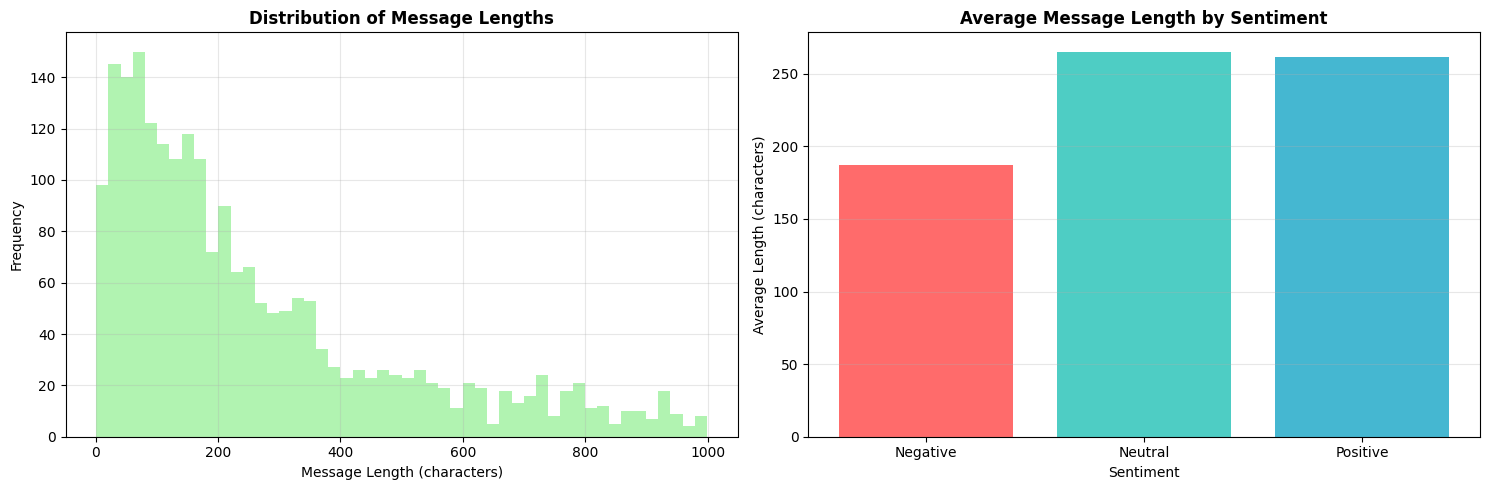


Average message length: 260.47 characters
Median message length: 179.00 characters
Maximum message length: 999.00 characters

4.5 KEY INSIGHTS SUMMARY
1. Sentiment Distribution: {'Neutral': np.int64(1654), 'Positive': np.int64(424), 'Negative': np.int64(113)}
2. Most active day: Friday with 339 messages
3. Sentiment with longest messages: Neutral
4. Overall positivity ratio: 19.4%


In [5]:
#@title Section 4: Exploratory Data Analysis (EDA)
print("=" * 60)
print("SECTION 4: EXPLORATORY DATA ANALYSIS")
print("=" * 60)

print("Performing comprehensive EDA...")

# 4.1 Basic Dataset Overview
print("\n" + "=" * 40)
print("4.1 BASIC DATASET OVERVIEW")
print("=" * 40)

print(f"Total number of messages: {len(df_final)}")
print(f"Number of unique employees: {df_final[employee_col].nunique()}")
print(f"Date range: {df_final['date_parsed'].min()} to {df_final['date_parsed'].max()}")
print(f"Number of months covered: {df_final['year_month'].nunique()}")

# 4.2 Sentiment Analysis by Various Dimensions
print("\n" + "=" * 40)
print("4.2 SENTIMENT ANALYSIS")
print("=" * 40)

# Sentiment distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Pie chart for sentiment distribution
sentiment_counts = df_final['sentiment'].value_counts()
axes[0,0].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
              colors=['#FF6B6B', '#4ECDC4', '#45B7D1'], startangle=90)
axes[0,0].set_title('Sentiment Distribution', fontweight='bold')

# Sentiment by month
monthly_sentiment = pd.crosstab(df_final['year_month'], df_final['sentiment'])
monthly_sentiment.plot(kind='bar', ax=axes[0,1], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0,1].set_title('Sentiment Trends Over Time', fontweight='bold')
axes[0,1].set_xlabel('Month')
axes[0,1].set_ylabel('Number of Messages')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].legend(title='Sentiment')

# Top employees by message volume
top_employees = df_final[employee_col].value_counts().head(10)
axes[1,0].bar(range(len(top_employees)), top_employees.values, color='skyblue')
axes[1,0].set_title('Top 10 Employees by Message Volume', fontweight='bold')
axes[1,0].set_xlabel('Employee')
axes[1,0].set_ylabel('Number of Messages')
axes[1,0].set_xticks(range(len(top_employees)))
axes[1,0].set_xticklabels([f"Emp {i+1}" for i in range(len(top_employees))], rotation=45)

# Sentiment proportion by employee (for top 10 employees)
top_emp_list = top_employees.index.tolist()
top_emp_sentiment = df_final[df_final[employee_col].isin(top_emp_list)]
sentiment_by_top_emp = pd.crosstab(top_emp_sentiment[employee_col], top_emp_sentiment['sentiment'])
sentiment_by_top_emp = sentiment_by_top_emp.div(sentiment_by_top_emp.sum(axis=1), axis=0)
sentiment_by_top_emp.plot(kind='bar', stacked=True, ax=axes[1,1],
                         color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1,1].set_title('Sentiment Distribution for Top 10 Employees', fontweight='bold')
axes[1,1].set_xlabel('Employee')
axes[1,1].set_ylabel('Proportion')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].legend(title='Sentiment')

plt.tight_layout()
plt.show()

# 4.3 Temporal Analysis
print("\n" + "=" * 40)
print("4.3 TEMPORAL ANALYSIS")
print("=" * 40)

# Messages over time
plt.figure(figsize=(12, 6))
df_final['date_parsed'].dt.date.value_counts().sort_index().plot()
plt.title('Daily Message Volume Over Time', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Number of Messages')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Weekly pattern
df_final['day_of_week'] = df_final['date_parsed'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_pattern = df_final['day_of_week'].value_counts().reindex(day_order)

plt.figure(figsize=(10, 6))
weekly_pattern.plot(kind='bar', color='lightcoral')
plt.title('Message Volume by Day of Week', fontweight='bold')
plt.xlabel('Day of Week')
plt.ylabel('Number of Messages')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 4.4 Message Length Analysis
print("\n" + "=" * 40)
print("4.4 MESSAGE LENGTH ANALYSIS")
print("=" * 40)

df_final['message_length'] = df_final[message_col].astype(str).apply(len)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Message length distribution
axes[0].hist(df_final['message_length'], bins=50, color='lightgreen', alpha=0.7)
axes[0].set_title('Distribution of Message Lengths', fontweight='bold')
axes[0].set_xlabel('Message Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].grid(alpha=0.3)

# Average message length by sentiment
avg_length_by_sentiment = df_final.groupby('sentiment')['message_length'].mean()
axes[1].bar(avg_length_by_sentiment.index, avg_length_by_sentiment.values,
           color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1].set_title('Average Message Length by Sentiment', fontweight='bold')
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Average Length (characters)')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAverage message length: {df_final['message_length'].mean():.2f} characters")
print(f"Median message length: {df_final['message_length'].median():.2f} characters")
print(f"Maximum message length: {df_final['message_length'].max():.2f} characters")

# 4.5 Key Insights Summary
print("\n" + "=" * 40)
print("4.5 KEY INSIGHTS SUMMARY")
print("=" * 40)

print(f"1. Sentiment Distribution: {dict(sentiment_counts)}")
print(f"2. Most active day: {weekly_pattern.idxmax()} with {weekly_pattern.max()} messages")
print(f"3. Sentiment with longest messages: {avg_length_by_sentiment.idxmax()}")
print(f"4. Overall positivity ratio: {(sentiment_counts.get('Positive', 0) / len(df_final) * 100):.1f}%")

SECTION 5: EMPLOYEE SCORE CALCULATION
Calculating monthly sentiment scores for each employee...
Monthly scores calculated successfully!
Number of employee-month combinations: 240

Sample of monthly scores:
                          from year_month  monthly_score
0  bobette.riner@ipgdirect.com    2010-01              0
1  bobette.riner@ipgdirect.com    2010-02              2
2  bobette.riner@ipgdirect.com    2010-03              1
3  bobette.riner@ipgdirect.com    2010-04              2
4  bobette.riner@ipgdirect.com    2010-05              2
5  bobette.riner@ipgdirect.com    2010-06              1
6  bobette.riner@ipgdirect.com    2010-07              1
7  bobette.riner@ipgdirect.com    2010-08              0
8  bobette.riner@ipgdirect.com    2010-09              2
9  bobette.riner@ipgdirect.com    2010-10              3


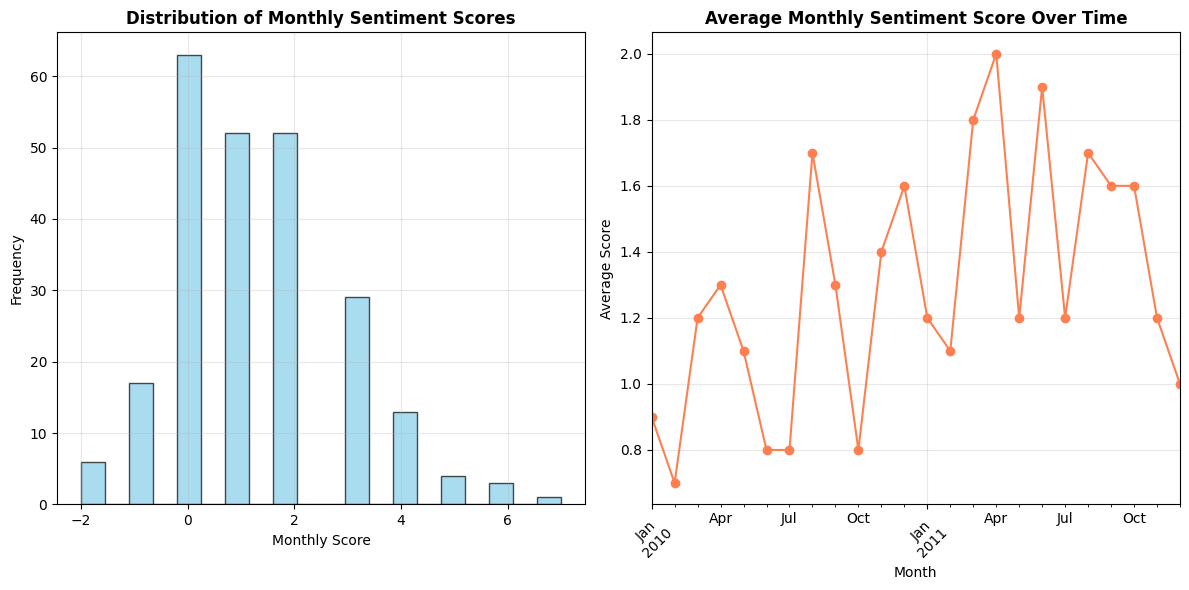


Monthly Score Statistics:
Average monthly score: 1.30
Median monthly score: 1.00
Highest monthly score: 7.00
Lowest monthly score: -2.00


In [6]:
#@title Section 5: Employee Score Calculation
print("=" * 60)
print("SECTION 5: EMPLOYEE SCORE CALCULATION")
print("=" * 60)

print("Calculating monthly sentiment scores for each employee...")

# Create score mapping
sentiment_scores = {
    'Positive': 1,
    'Negative': -1,
    'Neutral': 0
}

# Apply sentiment scores
df_final['sentiment_score'] = df_final['sentiment'].map(sentiment_scores)

# Calculate monthly scores for each employee
monthly_scores = df_final.groupby([employee_col, 'year_month'])['sentiment_score'].sum().reset_index()
monthly_scores = monthly_scores.rename(columns={'sentiment_score': 'monthly_score'})

print("Monthly scores calculated successfully!")
print(f"Number of employee-month combinations: {len(monthly_scores)}")

# Display sample of monthly scores
print("\nSample of monthly scores:")
print(monthly_scores.head(10))

# Visualize distribution of monthly scores
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(monthly_scores['monthly_score'], bins=20, color='skyblue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Monthly Sentiment Scores', fontweight='bold')
plt.xlabel('Monthly Score')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
# Average monthly score by month
avg_monthly_score = monthly_scores.groupby('year_month')['monthly_score'].mean()
avg_monthly_score.plot(kind='line', marker='o', color='coral')
plt.title('Average Monthly Sentiment Score Over Time', fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Average Score')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(f"\nMonthly Score Statistics:")
print(f"Average monthly score: {monthly_scores['monthly_score'].mean():.2f}")
print(f"Median monthly score: {monthly_scores['monthly_score'].median():.2f}")
print(f"Highest monthly score: {monthly_scores['monthly_score'].max():.2f}")
print(f"Lowest monthly score: {monthly_scores['monthly_score'].min():.2f}")

# Add monthly scores back to main dataframe for later use
df_final = df_final.merge(monthly_scores, on=[employee_col, 'year_month'], how='left')

SECTION 6: EMPLOYEE RANKING
Generating monthly employee rankings...

TOP POSITIVE EMPLOYEES BY MONTH:

2010-01:
  - eric.bass@enron.com: 3
  - don.baughman@enron.com: 2
  - patti.thompson@enron.com: 2

2010-02:
  - don.baughman@enron.com: 3
  - johnny.palmer@enron.com: 3
  - bobette.riner@ipgdirect.com: 2

2010-03:
  - sally.beck@enron.com: 5
  - johnny.palmer@enron.com: 3
  - eric.bass@enron.com: 2

2010-04:
  - john.arnold@enron.com: 3
  - bobette.riner@ipgdirect.com: 2
  - johnny.palmer@enron.com: 2

2010-05:
  - bobette.riner@ipgdirect.com: 2
  - eric.bass@enron.com: 2
  - kayne.coulter@enron.com: 2

2010-06:
  - sally.beck@enron.com: 4
  - johnny.palmer@enron.com: 3
  - don.baughman@enron.com: 2

2010-07:
  - eric.bass@enron.com: 4
  - lydia.delgado@enron.com: 2
  - bobette.riner@ipgdirect.com: 1

2010-08:
  - sally.beck@enron.com: 5
  - kayne.coulter@enron.com: 3
  - don.baughman@enron.com: 2

2010-09:
  - patti.thompson@enron.com: 3
  - rhonda.denton@enron.com: 3
  - bobette.rin

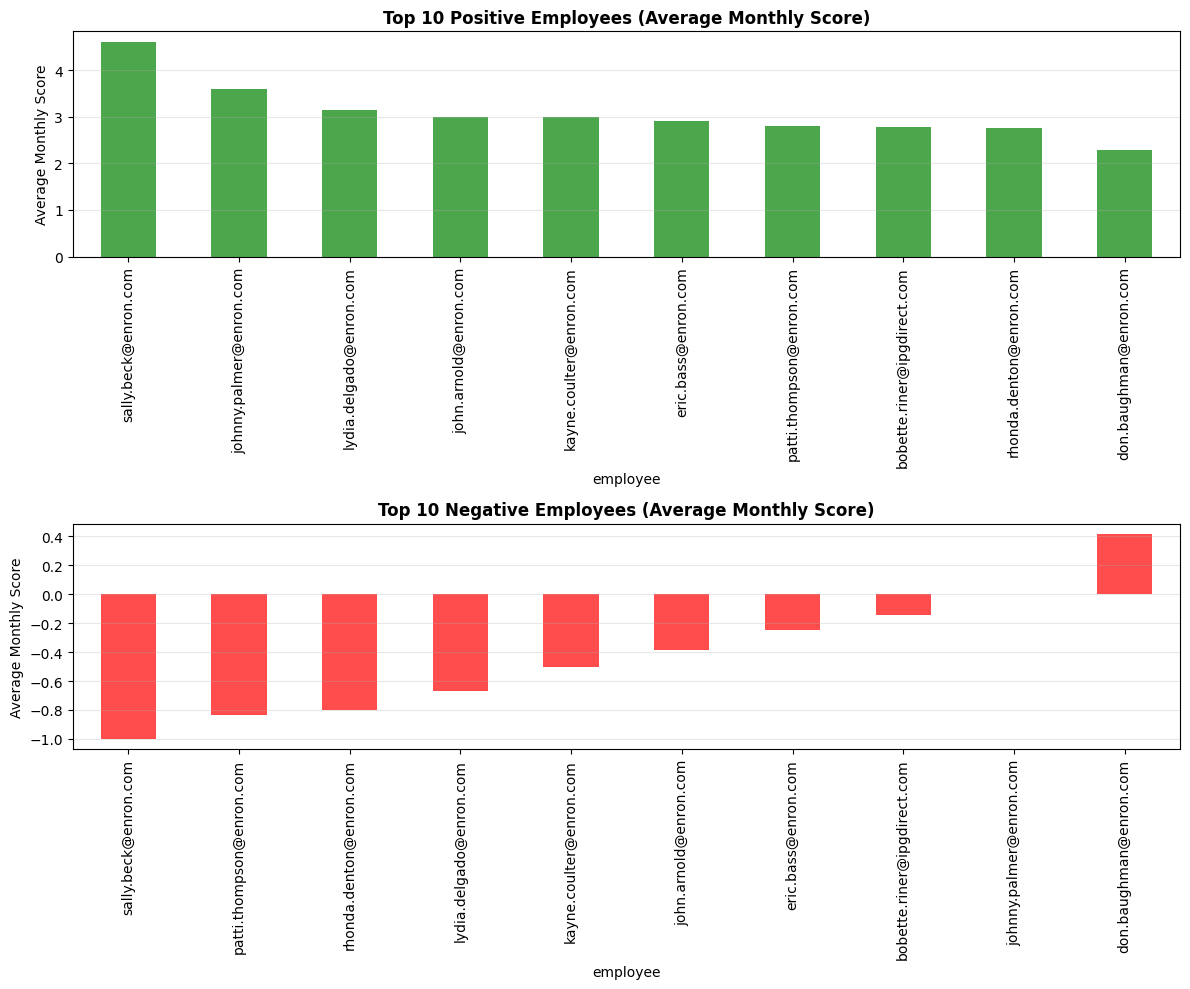

In [7]:
#@title Section 6: Employee Ranking
print("=" * 60)
print("SECTION 6: EMPLOYEE RANKING")
print("=" * 60)

print("Generating monthly employee rankings...")

# Get unique months
unique_months = monthly_scores['year_month'].unique()

top_positive_employees = []
top_negative_employees = []

for month in unique_months:
    month_data = monthly_scores[monthly_scores['year_month'] == month]

    # Get top 3 positive employees (highest scores)
    top_pos = month_data.nlargest(3, 'monthly_score')
    for _, row in top_pos.iterrows():
        top_positive_employees.append({
            'month': month,
            'employee': row[employee_col],
            'score': row['monthly_score'],
            'rank': 'Positive'
        })

    # Get top 3 negative employees (lowest scores)
    top_neg = month_data.nsmallest(3, 'monthly_score')
    for _, row in top_neg.iterrows():
        top_negative_employees.append({
            'month': month,
            'employee': row[employee_col],
            'score': row['monthly_score'],
            'rank': 'Negative'
        })

# Convert to DataFrames
df_top_positive = pd.DataFrame(top_positive_employees)
df_top_negative = pd.DataFrame(top_negative_employees)

print("\nTOP POSITIVE EMPLOYEES BY MONTH:")
print("=" * 40)
for month in unique_months:
    month_data = df_top_positive[df_top_positive['month'] == month]
    if not month_data.empty:
        print(f"\n{month}:")
        for _, row in month_data.iterrows():
            print(f"  - {row['employee']}: {row['score']}")

print("\nTOP NEGATIVE EMPLOYEES BY MONTH:")
print("=" * 40)
for month in unique_months:
    month_data = df_top_negative[df_top_negative['month'] == month]
    if not month_data.empty:
        print(f"\n{month}:")
        for _, row in month_data.iterrows():
            print(f"  - {row['employee']}: {row['score']}")

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Top positive employees
if not df_top_positive.empty:
    pivot_pos = df_top_positive.pivot_table(index='employee', columns='month', values='score', aggfunc='first')
    pivot_pos.mean(axis=1).nlargest(10).plot(kind='bar', ax=axes[0], color='green', alpha=0.7)
    axes[0].set_title('Top 10 Positive Employees (Average Monthly Score)', fontweight='bold')
    axes[0].set_ylabel('Average Monthly Score')
    axes[0].grid(axis='y', alpha=0.3)

# Top negative employees
if not df_top_negative.empty:
    pivot_neg = df_top_negative.pivot_table(index='employee', columns='month', values='score', aggfunc='first')
    pivot_neg.mean(axis=1).nsmallest(10).plot(kind='bar', ax=axes[1], color='red', alpha=0.7)
    axes[1].set_title('Top 10 Negative Employees (Average Monthly Score)', fontweight='bold')
    axes[1].set_ylabel('Average Monthly Score')
    axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

SECTION 7: FLIGHT RISK IDENTIFICATION
Identifying flight risk employees...

FLIGHT RISK IDENTIFICATION RESULTS:
Total employees analyzed: 10
Employees identified as flight risks: 1

Employees flagged as flight risks:
1. john.arnold@enron.com

Additional Analysis for Flight Risk Employees:
Total messages from flight risk employees: 256
Negative messages from flight risk employees: 20
Percentage of negative messages: 7.8%


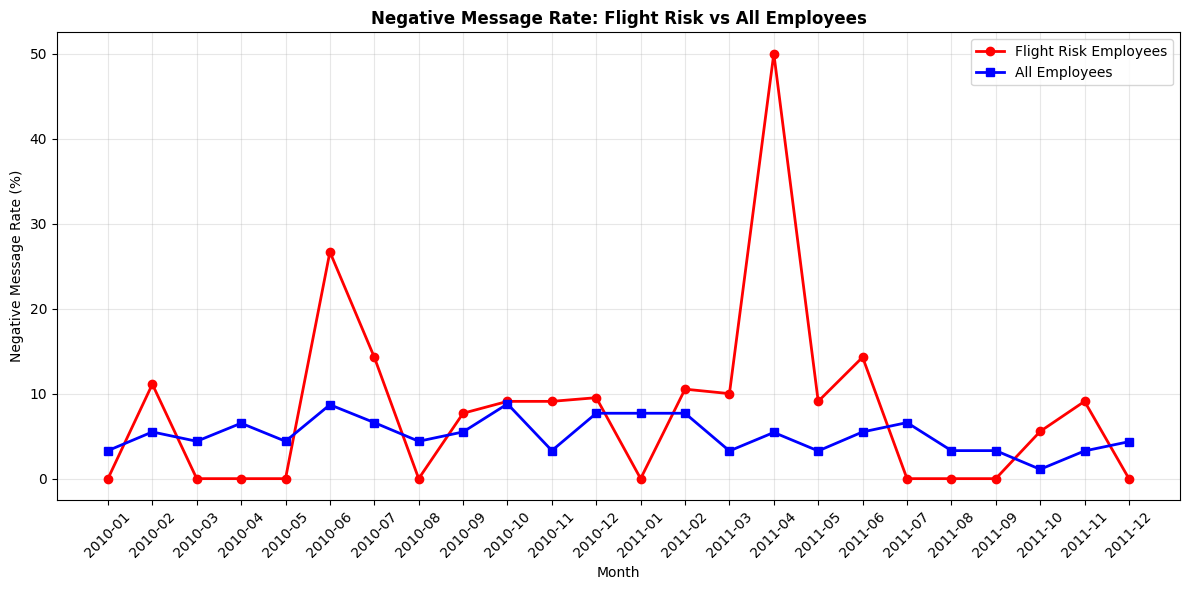

In [8]:
#@title Section 7: Flight Risk Identification
print("=" * 60)
print("SECTION 7: FLIGHT RISK IDENTIFICATION")
print("=" * 60)

print("Identifying flight risk employees...")

# Create a copy of the dataframe for flight risk analysis
flight_risk_df = df_final.copy()

# Sort by employee and date
flight_risk_df = flight_risk_df.sort_values([employee_col, 'date_parsed'])

# Identify negative messages
flight_risk_df['is_negative'] = (flight_risk_df['sentiment'] == 'Negative').astype(int)

# Function to check rolling 30-day window for negative messages
def check_flight_risk(employee_data):
    """
    Check if an employee has 4 or more negative messages in any rolling 30-day window
    """
    if len(employee_data) < 4:
        return False

    employee_data = employee_data.sort_values('date_parsed')
    # Convert to pandas Series for correct datetime operations
    dates = pd.Series(employee_data['date_parsed'].values)
    is_negative = employee_data['is_negative'].values

    for i in range(len(dates)):
        current_date = dates[i]
        # Find messages within 30 days from current_date
        mask = (dates >= current_date) & (dates <= current_date + timedelta(days=30))
        negative_count = is_negative[mask].sum()

        if negative_count >= 4:
            return True

    return False

# Group by employee and check for flight risk
flight_risk_employees = []
for employee, group in flight_risk_df.groupby(employee_col):
    if check_flight_risk(group):
        flight_risk_employees.append(employee)

print(f"\nFLIGHT RISK IDENTIFICATION RESULTS:")
print("=" * 50)
print(f"Total employees analyzed: {flight_risk_df[employee_col].nunique()}")
print(f"Employees identified as flight risks: {len(flight_risk_employees)}")

if flight_risk_employees:
    print("\nEmployees flagged as flight risks:")
    for i, emp in enumerate(flight_risk_employees, 1):
        print(f"{i}. {emp}")

    # Additional analysis for flight risk employees
    flight_risk_data = flight_risk_df[flight_risk_df[employee_col].isin(flight_risk_employees)]

    print(f"\nAdditional Analysis for Flight Risk Employees:")
    print(f"Total messages from flight risk employees: {len(flight_risk_data)}")
    print(f"Negative messages from flight risk employees: {flight_risk_data['is_negative'].sum()}")
    print(f"Percentage of negative messages: {(flight_risk_data['is_negative'].sum() / len(flight_risk_data) * 100):.1f}%")

    # Visualization
    plt.figure(figsize=(12, 6))

    # Negative message pattern for flight risk employees
    flight_risk_negative_pattern = flight_risk_data.groupby('year_month')['is_negative'].mean()
    overall_negative_pattern = flight_risk_df.groupby('year_month')['is_negative'].mean()

    plt.plot(flight_risk_negative_pattern.index.astype(str),
             flight_risk_negative_pattern.values * 100,
             marker='o', linewidth=2, label='Flight Risk Employees', color='red')
    plt.plot(overall_negative_pattern.index.astype(str),
             overall_negative_pattern.values * 100,
             marker='s', linewidth=2, label='All Employees', color='blue')

    plt.title('Negative Message Rate: Flight Risk vs All Employees', fontweight='bold')
    plt.xlabel('Month')
    plt.ylabel('Negative Message Rate (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

else:
    print("\nNo employees identified as flight risks based on the current criteria.")

SECTION 8: PREDICTIVE MODELING
Building predictive model for sentiment scores...

Engineering features...
Features used: ['monthly_msg_count', 'monthly_avg_length', 'monthly_total_length']
Dataset shape for modeling: (240, 3)
Training set size: (192, 3)
Testing set size: (48, 3)

Training Linear Regression model...

MODEL EVALUATION:
Mean Squared Error: 2.1982
R-squared Score: 0.1206

FEATURE IMPORTANCE (Coefficients):
                feature  coefficient
0     monthly_msg_count     0.795407
2  monthly_total_length    -0.171363
1    monthly_avg_length     0.071219


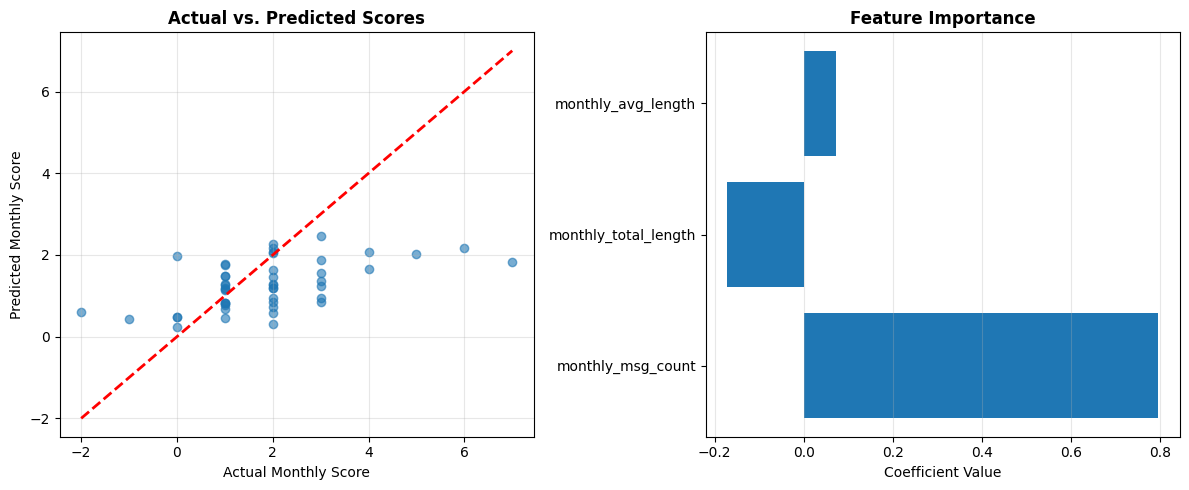


MODEL INTERPRETATION:
The linear regression model attempts to predict the monthly sentiment score based on message characteristics.
The R-squared value of 0.12 suggests that message count and length have some ability to predict sentiment scores.
The most influential feature is 'monthly_msg_count'.


In [9]:
#@title Section 8: Predictive Modeling
print("=" * 60)
print("SECTION 8: PREDICTIVE MODELING")
print("=" * 60)

print("Building predictive model for sentiment scores...")

# Prepare features for modeling
model_df = df_final.copy()
# Ensure message_length column exists if it wasn't created in EDA
if 'message_length' not in model_df.columns:
    model_df['message_length'] = model_df[message_col].astype(str).apply(len)

# Feature Engineering
print("\nEngineering features...")

# Get monthly counts and lengths
monthly_features = model_df.groupby([employee_col, 'year_month']).agg(
    monthly_msg_count=('sentiment_score', 'size'),
    monthly_avg_length=('message_length', 'mean'),
    monthly_total_length=('message_length', 'sum')
).reset_index()

# Add the target variable (the score we want to predict)
# First need to calculate monthly_scores if not already done
sentiment_scores_map = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
model_df['sentiment_score'] = model_df['sentiment'].map(sentiment_scores_map)
monthly_scores = model_df.groupby([employee_col, 'year_month'])['sentiment_score'].sum().reset_index().rename(columns={'sentiment_score': 'monthly_score'})

monthly_features = monthly_features.merge(monthly_scores, on=[employee_col, 'year_month'])

# This prevents data leakage and creates a more realistic model.
feature_columns = [
    'monthly_msg_count',
    'monthly_avg_length',
    'monthly_total_length'
]

X = monthly_features[feature_columns].fillna(0)
y = monthly_features['monthly_score']

print(f"Features used: {feature_columns}")
print(f"Dataset shape for modeling: {X.shape}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Linear Regression model
print("\nTraining Linear Regression model...")
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nMODEL EVALUATION:")
print("=" * 30)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared Score: {r2:.4f}")

# Feature importance (coefficients)
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'coefficient': model.coef_
}).sort_values('coefficient', key=abs, ascending=False)

print("\nFEATURE IMPORTANCE (Coefficients):")
print("=" * 40)
print(feature_importance)

# Visualization of model performance
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Monthly Score')
plt.ylabel('Predicted Monthly Score')
plt.title('Actual vs. Predicted Scores', fontweight='bold')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.barh(feature_importance['feature'], feature_importance['coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Feature Importance', fontweight='bold')
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nMODEL INTERPRETATION:")
print("=" * 30)
print("The linear regression model attempts to predict the monthly sentiment score based on message characteristics.")
print(f"The R-squared value of {r2:.2f} suggests that message count and length have some ability to predict sentiment scores.")
print(f"The most influential feature is '{feature_importance.iloc[0]['feature']}'.")

SECTION 9: FINAL SUMMARY AND REPORTING
Generating final summary report...

FINAL PROJECT SUMMARY

OVERVIEW:
• Total Employees Analyzed: 10
• Total Messages Processed: 2191
• Analysis Period: 24 months

SENTIMENT DISTRIBUTION:
• Positive Messages: 424 (19.4%)
• Negative Messages: 113 (5.2%)
• Neutral Messages: 1654 (75.5%)

KEY FINDINGS:
• Employees Identified as Flight Risks: 1
• Flight Risk Employees: john.arnold@enron.com

PREDICTIVE MODEL PERFORMANCE:
• R-squared Score: 0.1206
• Model can explain 12.1% of variance in monthly scores

TOP POSITIVE EMPLOYEES (Overall):
  1. johnny.palmer@enron.com: 2.04
  2. bobette.riner@ipgdirect.com: 1.75
  3. sally.beck@enron.com: 1.75

TOP NEGATIVE EMPLOYEES (Overall):
  1. john.arnold@enron.com: 0.67
  2. kayne.coulter@enron.com: 0.67
  3. rhonda.denton@enron.com: 0.79


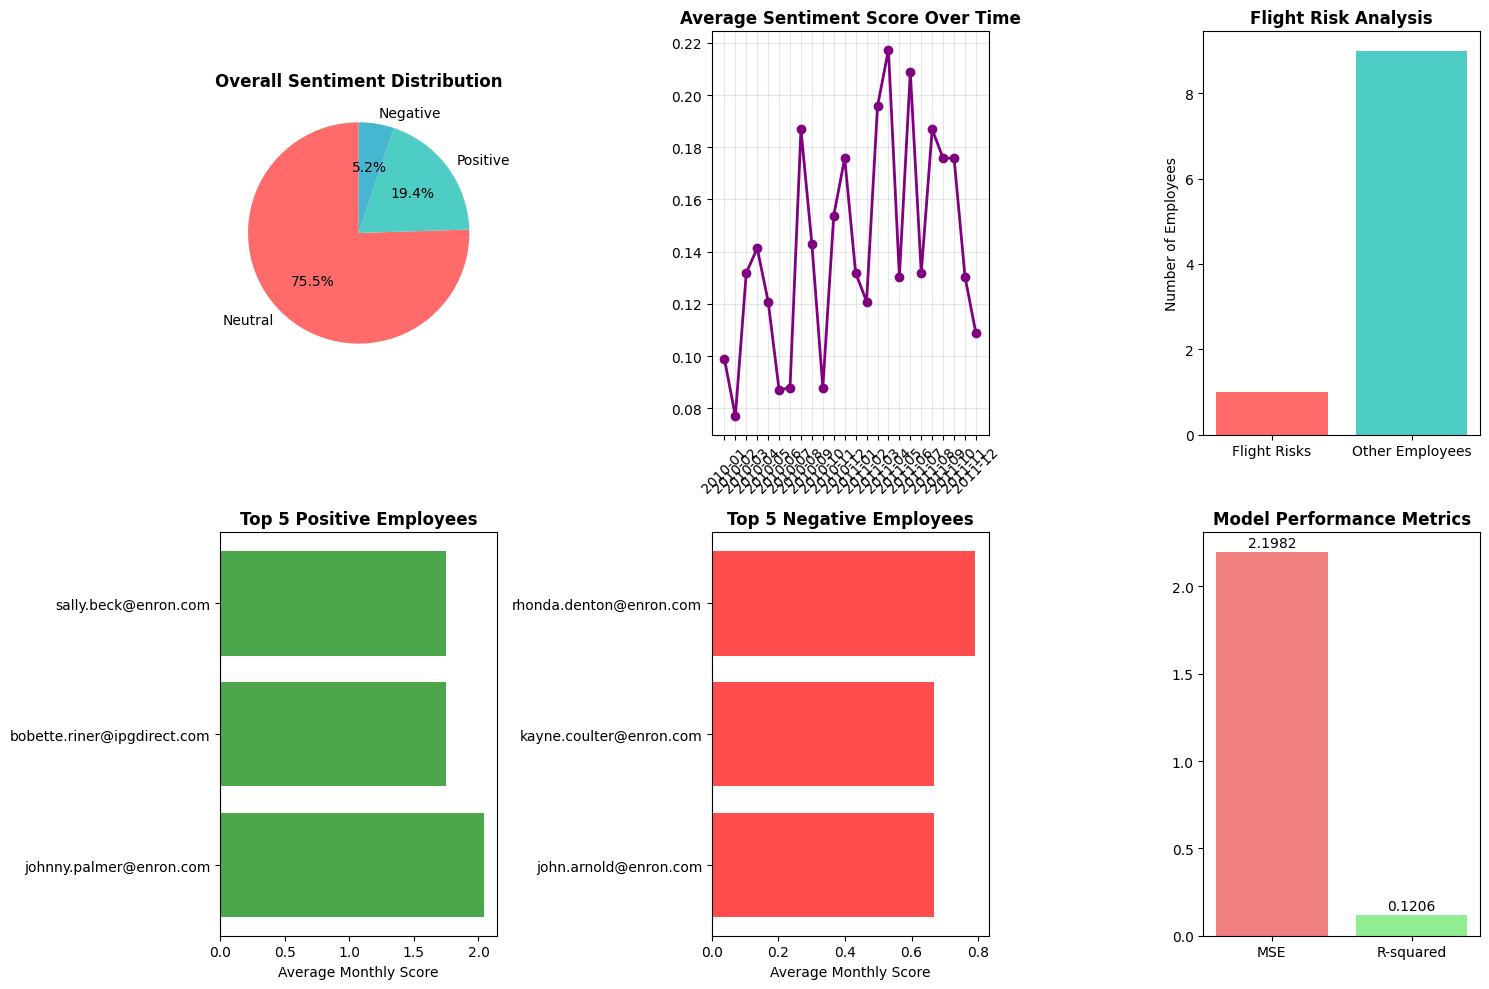


RECOMMENDATIONS

1. EMPLOYEE ENGAGEMENT:
   ⚠️ Consider implementing additional employee engagement initiatives

2. FLIGHT RISK MANAGEMENT:
   ⚠️ 1 employees identified as flight risks - recommend:
     • One-on-one check-ins with HR
     • Review workload and work environment
     • Consider retention strategies

3. SENTIMENT MONITORING:
   • Continue regular sentiment analysis
   • Track monthly sentiment trends
   • Address negative sentiment spikes promptly

4. PREDICTIVE INSIGHTS:
   • Use the model to predict potential sentiment declines
   • Focus on key features identified in model analysis
   • Implement proactive measures based on predictions


In [10]:
#@title Section 9: Final Summary and Reporting
print("=" * 60)
print("SECTION 9: FINAL SUMMARY AND REPORTING")
print("=" * 60)

print("Generating final summary report...")

# Create summary statistics
total_employees = df_final[employee_col].nunique()
total_messages = len(df_final)
total_months = df_final['year_month'].nunique()

# Sentiment summary
sentiment_summary = df_final['sentiment'].value_counts()
positive_pct = (sentiment_summary.get('Positive', 0) / total_messages) * 100
negative_pct = (sentiment_summary.get('Negative', 0) / total_messages) * 100
neutral_pct = (sentiment_summary.get('Neutral', 0) / total_messages) * 100

# Flight risk summary
flight_risk_count = len(flight_risk_employees)

# Model performance summary
model_r2 = r2_score(y_test, y_pred)

print("\n" + "=" * 50)
print("FINAL PROJECT SUMMARY")
print("=" * 50)

print(f"\nOVERVIEW:")
print(f"• Total Employees Analyzed: {total_employees}")
print(f"• Total Messages Processed: {total_messages}")
print(f"• Analysis Period: {total_months} months")

print(f"\nSENTIMENT DISTRIBUTION:")
print(f"• Positive Messages: {sentiment_summary.get('Positive', 0)} ({positive_pct:.1f}%)")
print(f"• Negative Messages: {sentiment_summary.get('Negative', 0)} ({negative_pct:.1f}%)")
print(f"• Neutral Messages: {sentiment_summary.get('Neutral', 0)} ({neutral_pct:.1f}%)")

print(f"\nKEY FINDINGS:")
print(f"• Employees Identified as Flight Risks: {flight_risk_count}")
if flight_risk_count > 0:
    print(f"• Flight Risk Employees: {', '.join(flight_risk_employees)}")
else:
    print(f"• Flight Risk Employees: None identified")

print(f"\nPREDICTIVE MODEL PERFORMANCE:")
print(f"• R-squared Score: {model_r2:.4f}")
print(f"• Model can explain {model_r2*100:.1f}% of variance in monthly scores")

print(f"\nTOP POSITIVE EMPLOYEES (Overall):")
top_overall_positive = monthly_scores.groupby(employee_col)['monthly_score'].mean().nlargest(3)
for i, (emp, score) in enumerate(top_overall_positive.items(), 1):
    print(f"  {i}. {emp}: {score:.2f}")

print(f"\nTOP NEGATIVE EMPLOYEES (Overall):")
top_overall_negative = monthly_scores.groupby(employee_col)['monthly_score'].mean().nsmallest(3)
for i, (emp, score) in enumerate(top_overall_negative.items(), 1):
    print(f"  {i}. {emp}: {score:.2f}")

# Create comprehensive visual summary
plt.figure(figsize=(15, 10))

# 1. Overall sentiment distribution
plt.subplot(2, 3, 1)
plt.pie(sentiment_summary.values, labels=sentiment_summary.index, autopct='%1.1f%%',
        colors=['#FF6B6B', '#4ECDC4', '#45B7D1'], startangle=90)
plt.title('Overall Sentiment Distribution', fontweight='bold')

# 2. Monthly trend
plt.subplot(2, 3, 2)
monthly_sentiment_trend = df_final.groupby('year_month')['sentiment_score'].mean()
plt.plot(monthly_sentiment_trend.index.astype(str), monthly_sentiment_trend.values,
         marker='o', linewidth=2, color='purple')
plt.title('Average Sentiment Score Over Time', fontweight='bold')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)

# 3. Flight risk analysis
plt.subplot(2, 3, 3)
risk_labels = ['Flight Risks', 'Other Employees']
risk_counts = [flight_risk_count, total_employees - flight_risk_count]
colors = ['#FF6B6B', '#4ECDC4']
plt.bar(risk_labels, risk_counts, color=colors)
plt.title('Flight Risk Analysis', fontweight='bold')
plt.ylabel('Number of Employees')

# 4. Top positive employees
plt.subplot(2, 3, 4)
top_pos_names = list(top_overall_positive.index)[:5]
top_pos_scores = list(top_overall_positive.values)[:5]
plt.barh(top_pos_names, top_pos_scores, color='green', alpha=0.7)
plt.title('Top 5 Positive Employees', fontweight='bold')
plt.xlabel('Average Monthly Score')

# 5. Top negative employees
plt.subplot(2, 3, 5)
top_neg_names = list(top_overall_negative.index)[:5]
top_neg_scores = list(top_overall_negative.values)[:5]
plt.barh(top_neg_names, top_neg_scores, color='red', alpha=0.7)
plt.title('Top 5 Negative Employees', fontweight='bold')
plt.xlabel('Average Monthly Score')

# 6. Model performance
plt.subplot(2, 3, 6)
metrics = ['MSE', 'R-squared']
values = [mse, r2]
colors = ['lightcoral', 'lightgreen']
bars = plt.bar(metrics, values, color=colors)
plt.title('Model Performance Metrics', fontweight='bold')
# Add value labels on bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\n" + "=" * 50)
print("RECOMMENDATIONS")
print("=" * 50)

print("\n1. EMPLOYEE ENGAGEMENT:")
if positive_pct > 50:
    print("   ✓ Positive sentiment is dominant - maintain current engagement strategies")
else:
    print("   ⚠️ Consider implementing additional employee engagement initiatives")

print("\n2. FLIGHT RISK MANAGEMENT:")
if flight_risk_count > 0:
    print(f"   ⚠️ {flight_risk_count} employees identified as flight risks - recommend:")
    print("     • One-on-one check-ins with HR")
    print("     • Review workload and work environment")
    print("     • Consider retention strategies")
else:
    print("   ✓ No immediate flight risks identified - continue monitoring")

print("\n3. SENTIMENT MONITORING:")
print("   • Continue regular sentiment analysis")
print("   • Track monthly sentiment trends")
print("   • Address negative sentiment spikes promptly")

print("\n4. PREDICTIVE INSIGHTS:")
print("   • Use the model to predict potential sentiment declines")
print("   • Focus on key features identified in model analysis")
print("   • Implement proactive measures based on predictions")